In [2]:
from scipy.stats import norm, genextreme
import numpy.random as rnd
from numpy.fft import rfftfreq, irfft
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Polygon
from yellowbrick.cluster import KElbowVisualizer
import mfdfa
import statsfuncs

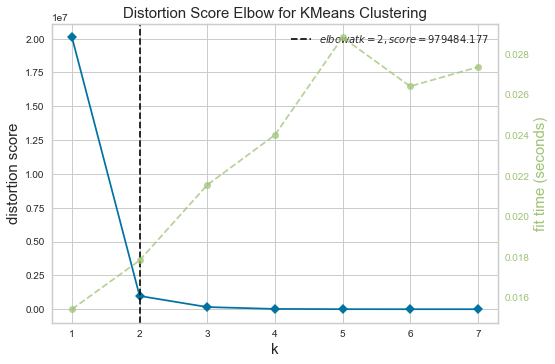

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

42


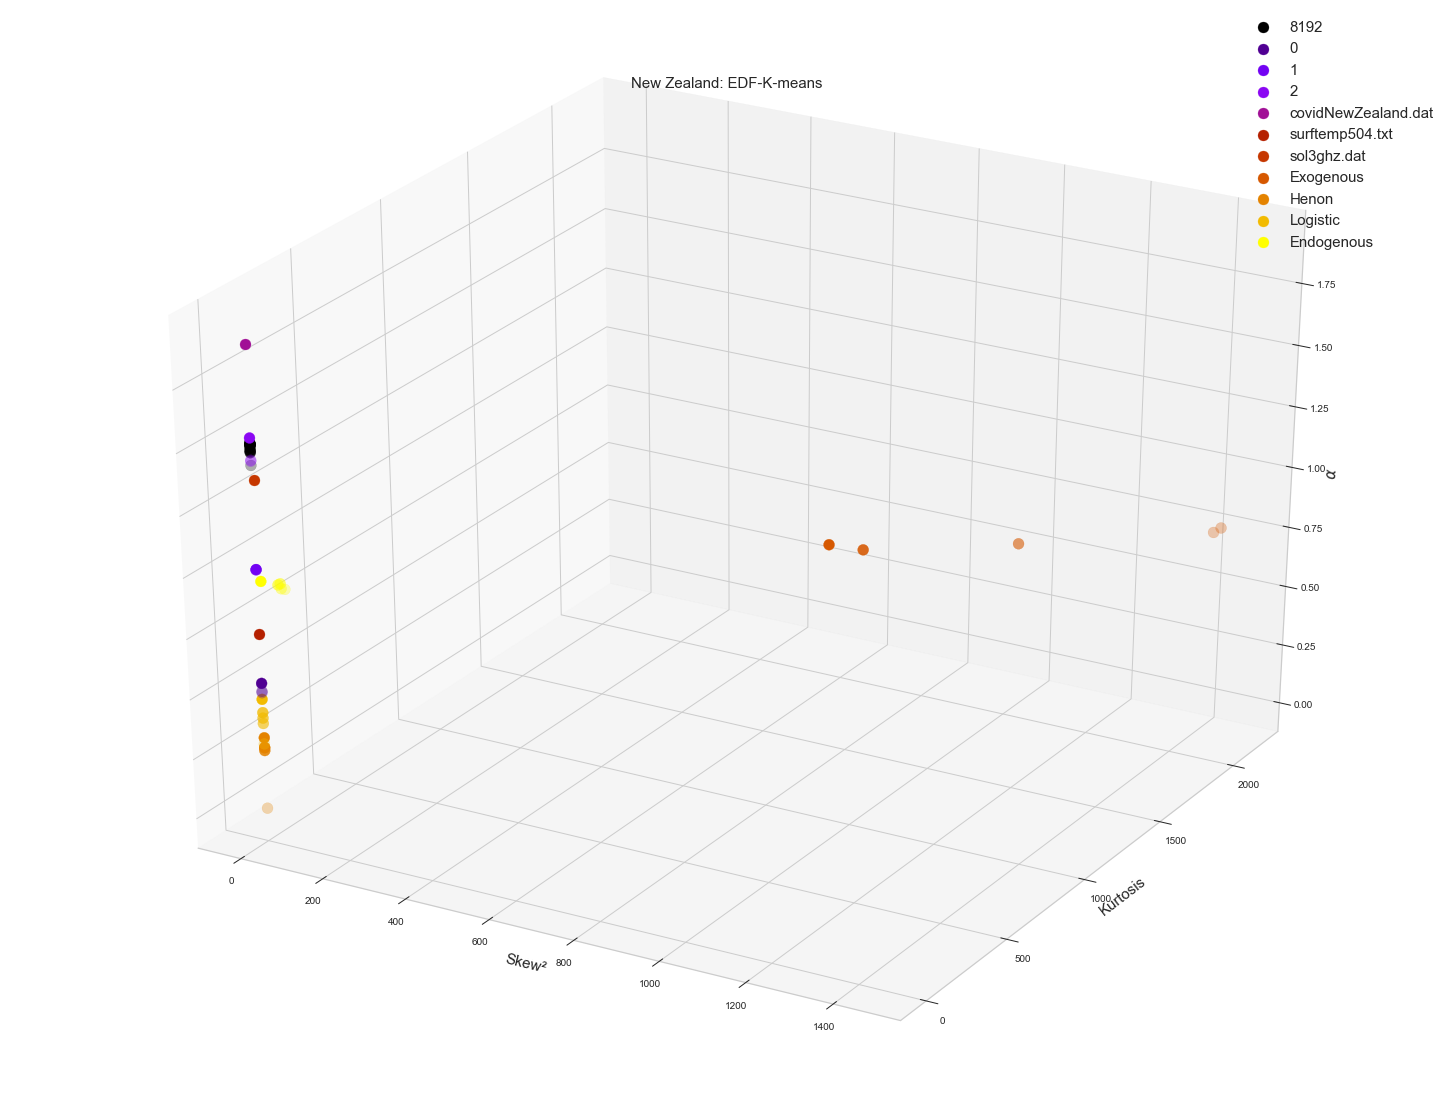

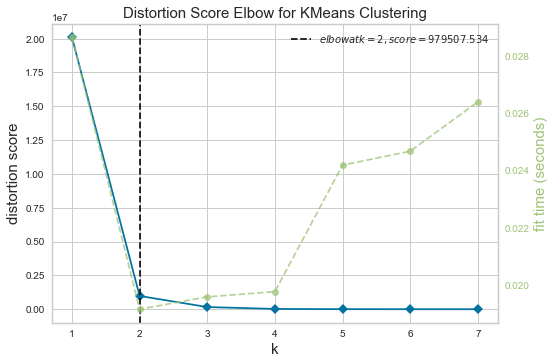

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

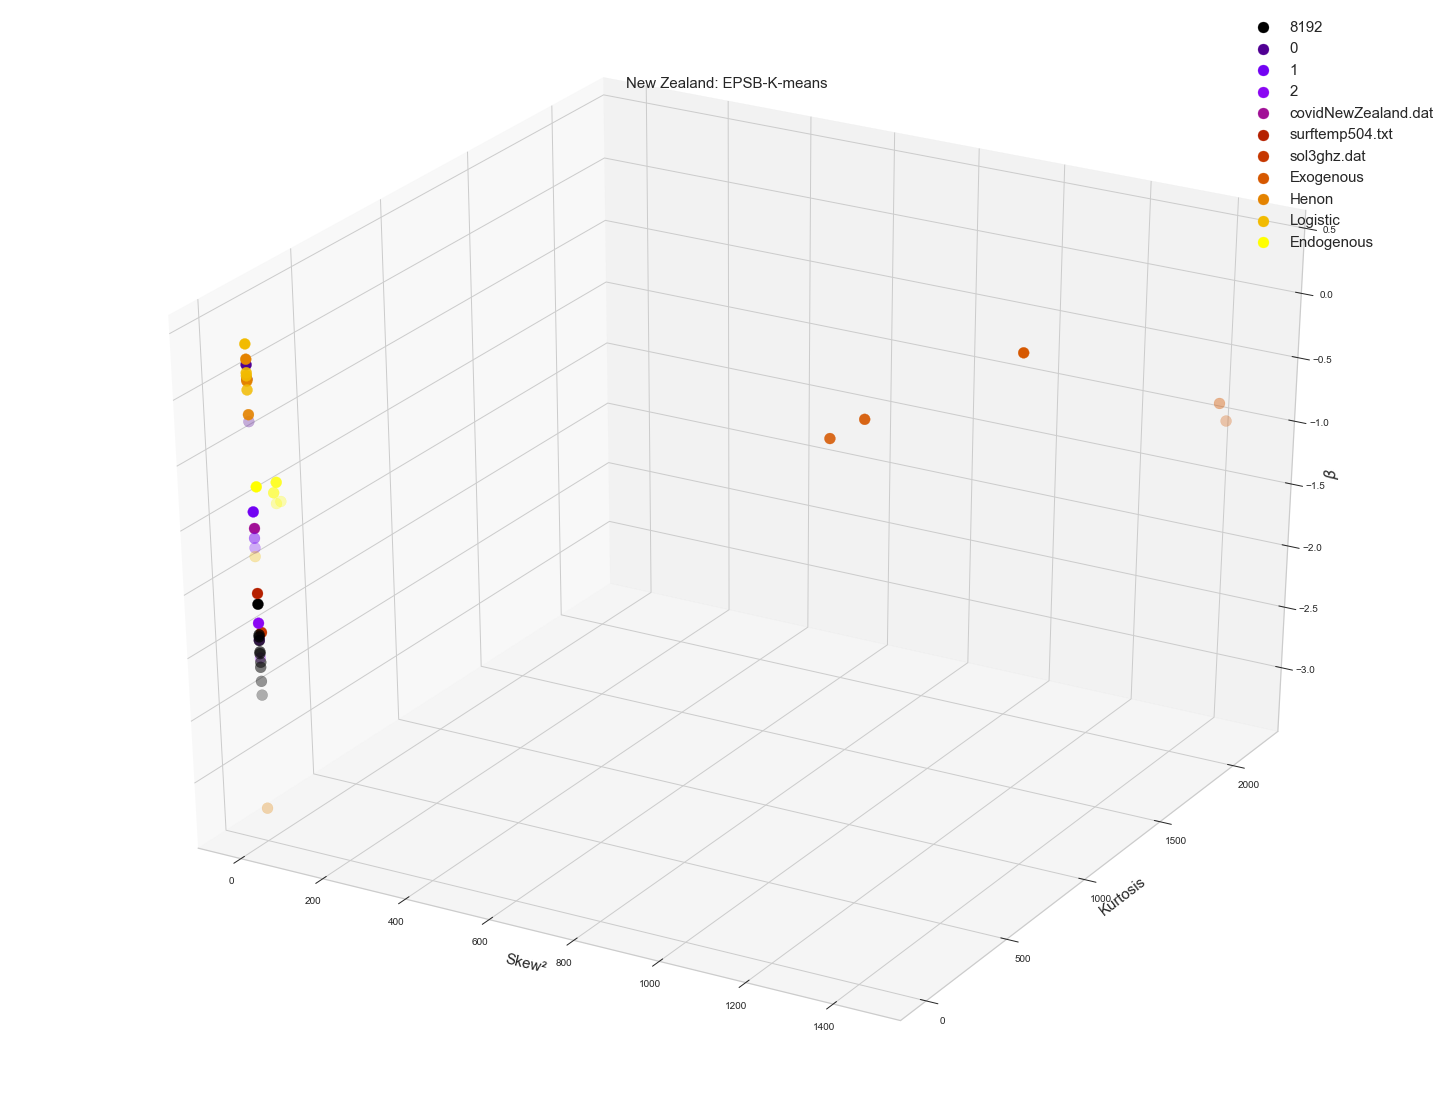

In [15]:
def pmodel(seriestype):
    if(seriestype=="Endogenous"):
        p=0.32 + 0.1*rnd.uniform()
        slope= 0.4
    else:
        p=0.18 + 0.1*rnd.uniform()
        slope=0.7
    noValues=8192

    noOrders = int(np.ceil(np.log2(noValues)))
    
    y = np.array([1])
    for n in range(noOrders):
        y = next_step_1d(y, p)
    
    if (slope):
        fourierCoeff = fractal_spectrum_1d(noValues, slope/2)
        meanVal = np.mean(y)
        stdy = np.std(y)
        x = np.fft.ifft(y - meanVal)
        phase = np.angle(x)
        x = fourierCoeff*np.exp(1j*phase)
        x = np.fft.fft(x).real
        x *= stdy/np.std(x)
        x += meanVal
    else:
        x = y
    return x[0:noValues], y[0:noValues]

def powerlaw_psd_gaussian(exponent, size=8192, fmin=0):
    """Gaussian (1/f)**beta noise.
    Based on the algorithm in:
    Timmer, J. and Koenig, M.:
    On generating power law noise.
    Astron. Astrophys. 300, 707-710 (1995)
    Normalised to unit variance
    Parameters:
    -----------
    exponent : float
        The power-spectrum of the generated noise is proportional to
        S(f) = (1 / f)**beta
        flicker / pink noise:   exponent beta = 1
        brown noise:            exponent beta = 2
        Furthermore, the autocorrelation decays proportional to lag**-gamma
        with gamma = 1 - beta for 0 < beta < 1.
        There may be finite-size issues for beta close to one.
    shape : int or iterable
        The output has the given shape, and the desired power spectrum in
        the last coordinate. That is, the last dimension is taken as time,
        and all other components are independent.
    fmin : float, optional
        Low-frequency cutoff.
        Default: 0 corresponds to original paper. It is not actually
        zero, but 1/samples.
    Returns
    -------
    out : array
        The samples.
    Examples:
    ---------
    # generate 1/f noise == pink noise == flicker noise
    >>> import colorednoise as cn
    >>> y = cn.powerlaw_psd_gaussian(1, 5)
    """

    try:
        size = list(size)
    except TypeError:
        size = [size]

    samples = size[-1]
    

    f = rfftfreq(samples)
    s_scale = f
    fmin = max(fmin, 1./samples)
    ix   = np.sum(s_scale < fmin) 
    if ix and ix < len(s_scale):
        s_scale[:ix] = s_scale[ix]
    s_scale = s_scale**(-exponent/2.)
    
    w  = s_scale[1:].copy()
    w[-1] *= (1 + (samples % 2)) / 2. 
    sigma = 2 * np.sqrt(np.sum(w**2)) / samples
    
    size[-1] = len(f)

    dims_to_add = len(size) - 1
    s_scale     = s_scale[(np.newaxis,) * dims_to_add + (Ellipsis,)]
    

    sr = rnd.normal(scale=s_scale, size=size)
    si = rnd.normal(scale=s_scale, size=size)

    if not (samples % 2): si[...,-1] = 0
    
    si[...,0] = 0    
    s  = sr + 1J * si
    y = irfft(s, n=samples, axis=-1) / sigma
    x=range(0,len(y))
    return x,y

def randomseries(n):
    res = n/12
    df = pd.DataFrame(np.random.randn(n) * np.sqrt(res) * np.sqrt(1 / 128.)).cumsum()
    a=df[0].tolist()
    a=statsfuncs.normalize(a)
    x=range(0,n)
    return x,a

def Logistic(dummy):
    N=8192
    rho=3.85 + 0.15*np.random.uniform()
    tau = 1.1
    x = [0.001]
    y = [0.001]
    for i in range(1,N):
      y.append( tau*x[-1] )
      x.append( rho*x[-1]*(1.0-x[-1]))
    return y,x

def HenonMap(dummy):
    N=8192
    a=1.350 + 0.05*np.random.uniform()
    b=0.21 + 0.08*np.random.uniform()
    x = [0.1]
    y = [0.3]
    for i in range(1,N):
        y.append(b * x[-1])
        x.append(y[-2] + 1.0 - a *x[-1]*x[-1])
    return x,y

def makespaces62(s2, k, alpha, beta, legend, title, ilist):
    SMALL_SIZE = 10
    MEDIUM_SIZE = 15
    BIGGER_SIZE = 20
    
    plt.rc('font', size=SMALL_SIZE)         
    plt.rc('axes', titlesize=MEDIUM_SIZE) 
    plt.rc('axes', labelsize=MEDIUM_SIZE)    
    plt.rc('xtick', labelsize=SMALL_SIZE)   
    plt.rc('ytick', labelsize=SMALL_SIZE) 
    plt.rc('legend', fontsize=MEDIUM_SIZE)  
    plt.rc('figure', titlesize=BIGGER_SIZE)  
    kk=pd.DataFrame({'Skew²': s2, 'Kurtosis': k, 'Alpha': alpha, 'Beta': beta, "Entity": ilist})
    K=8
    model=KMeans()
    visualizer = KElbowVisualizer(model, k=(1,K))
    kIdx=visualizer.fit(kk.drop(columns=["Beta", "Entity"]))
    visualizer.show()      
    kIdx=kIdx.elbow_value_
    model=KMeans(n_clusters=kIdx).fit(kk.drop(columns=["Beta", "Entity"]))
    print(len(model.labels_))
    fig = plt.figure(figsize=(20,15))
    ax = Axes3D(fig)
    cmap = plt.get_cmap('gnuplot')
    ilist2=list(set(ilist))
    clr = [cmap(i) for i in np.linspace(0, 1, len(ilist2))]
    for i in range(0,len(ilist2)):
        ind = (kk["Entity"]==ilist2[i])
        ax.scatter(kk["Skew²"][ind],kk["Kurtosis"][ind], kk["Alpha"][ind], s=120, c=clr[i], label=ilist2[i])
    ax.set_xlabel("Skew²")
    ax.set_ylabel("Kurtosis")
    ax.set_zlabel(r"$\alpha$")
    ax.legend()
    plt.title(title+": EDF-K-means")
    plt.savefig("datasetandcovidEDF.png")
    plt.show()
    kk=pd.DataFrame({'Skew²': s2, 'Kurtosis': k, 'Alpha': alpha, 'Beta': beta, "Entity": ilist}, index=model.labels_)
    kk.sort_index(inplace=True)
    kk.to_csv("clusteringalpha.csv")
    model=KMeans()
    visualizer = KElbowVisualizer(model, k=(1,K))
    kIdx=visualizer.fit(kk.drop(columns=["Alpha", "Entity"]))        
    visualizer.show()        
    kIdx=kIdx.elbow_value_
    model=KMeans(n_clusters=kIdx).fit(kk.drop(columns=["Alpha", "Entity"]))
    fig = plt.figure(figsize=(20,15))
    ax = Axes3D(fig)
    cmap = plt.get_cmap('gnuplot')
    clr = [cmap(i) for i in np.linspace(0, 1, len(ilist2))]
    for i in range(0,len(ilist2)):
        ind = (kk["Entity"]==ilist2[i])
        ax.scatter(kk["Skew²"][ind],kk["Kurtosis"][ind], kk["Beta"][ind], s=120, c=clr[i], label=ilist2[i])
    ax.set_xlabel("Skew²")
    ax.set_ylabel("Kurtosis")
    ax.set_zlabel(r"$\beta$")
    ax.legend()
    plt.title(title+": EPSB-K-means")
    plt.savefig("datasetandcovidEPSB.png")
    plt.show()
    kk=pd.DataFrame({'Skew²': s2, 'Kurtosis': k, 'Alpha': alpha, 'Beta': beta, "Entity": ilist}, index=model.labels_)
    kk.sort_index(inplace=True)
    kk.to_csv("clusteringbeta.csv")

def next_step_1d(y, p):
    y2 = np.zeros(y.size*2)
    sign = np.random.rand(1, y.size) - 0.5
    sign /= np.abs(sign)
    y2[0:2*y.size:2] = y + sign*(1-2*p)*y
    y2[1:2*y.size+1:2] = y - sign*(1-2*p)*y
    
    return y2


def fractal_spectrum_1d(noValues, slope):
    ori_vector_size = noValues
    ori_half_size = ori_vector_size//2
    a = np.zeros(ori_vector_size)
    
    for t2 in range(ori_half_size):
        index = t2
        t4 = 1 + ori_vector_size - t2
        if (t4 >= ori_vector_size):
            t4 = t2
        coeff = (index + 1)**slope
        a[t2] = coeff
        a[t4] = coeff
        
    a[1] = 0
    
    return a

def makeseries(func, iterationlist, amount, title="Nada", graphs=False):
    values=[]
    ilist=[]
    rawdata=[]
    for i in iterationlist:
        for j in range(amount):
            x,y=func(i)
            alfa,xdfa,ydfa, reta = statsfuncs.dfa1d(y,1)
            freqs, power, xdata, ydata, amp, index, powerlaw, INICIO, FIM = statsfuncs.psd(y)
            values.append([statsfuncs.variance(y), statsfuncs.skewness(y), statsfuncs.kurtosis(y)+3, alfa, index])
            ilist.append(i)
            if graphs==True:
                plt.plot(alphal, falpha, 'ko-', label=str(j))
        if graphs==True:
            plt.title("Espectro de Singularidade, para: {} {}".format(title,i))
            plt.xlabel(r'$\alpha$')
            plt.ylabel(r'$f(\alpha)$')
            plt.grid('on', which = 'major')
            plt.savefig("{}singularityspectrum{}".format(title,i))
            plt.show()
        rawdata.append([i,x,y, alfa, xdfa, ydfa, reta, freqs, power, xdata, ydata, amp, index, powerlaw, INICIO, FIM])
    return values, ilist, rawdata

def compararSeriesTemporais():
    namefile = ["sol3ghz.dat", "surftemp504.txt", "covidNewZealand.dat"]
    ilist = namefile
    d = []
    for file in namefile:
        fileread = open(file)
        y = []
        for line in fileread:
            y.append(float(line))
        alfa, xdfa, ydfa, reta = statsfuncs.dfa1d(y, 1)
        freqs, power, xdata, ydata, amp, index, powerlaw, INICIO, FIM = statsfuncs.psd(y)
        d.append([statsfuncs.variance(y), statsfuncs.skewness(y), statsfuncs.kurtosis(y) + 3, alfa, index, 0])
    QTD = 10
    d2, ilist2, rawdata = makeseries(randomseries, [8192], QTD)
    for i in d2:
        d.append(i)
    for j in ilist2:
        ilist.append(j)

    d2, ilist2, rawdata = makeseries(powerlaw_psd_gaussian, range(0, 3), QTD // 3)
    for i in d2:
        d.append(i)
    for j in ilist2:
        ilist.append(j)
    d2, ilist2, rawdata = makeseries(pmodel, ["Exogenous", "Endogenous"], QTD // 2)
    for i in d2:
        d.append(i)
    for j in ilist2:
        ilist.append(j)
    d2, ilist2, rawdata = makeseries(Logistic, ["Logistic"], QTD // 2)
    for i in d2:
        d.append(i)
    for j in ilist2:
        ilist.append(j)
    d2, ilist2, rawdata = makeseries(HenonMap, ["Henon"], QTD // 2)
    for i in d2:
        d.append(i)
    for j in ilist2:
        ilist.append(j)
    s2 = []
    k = []
    alpha = []
    beta = []
    for i in range(len(d)):
        s2.append(d[i][1] ** 2)
        k.append(d[i][2])
        alpha.append(d[i][3])
        beta.append(d[i][4])
    makespaces62(s2, k, alpha, beta, "All signals and New Zealand Covid data", "New Zealand", ilist)
    return d

def main():
    compararSeriesTemporais()
    
main()